In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

In [2]:
# Get the data
qqq = yf.download(tickers="QQQ", period="24h", interval="1m")
btc = yf.download(tickers="BTC-USD", period="24h", interval="1m")

# Print the data
print(qqq.tail())
print(btc.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                                 Open        High         Low       Close  \
Datetime                                                                    
2022-04-19 15:56:00-04:00  345.600006  345.848999  345.489990  345.720001   
2022-04-19 15:57:00-04:00  345.730011  345.940002  345.589996  345.880005   
2022-04-19 15:58:00-04:00  345.880005  346.100006  345.709991  346.049988   
2022-04-19 15:59:00-04:00  346.364990  346.450012  346.079987  346.130005   
2022-04-19 16:00:00-04:00  346.260010  346.260010  346.260010  346.260010   

                            Adj Close   Volume  
Datetime                                        
2022-04-19 15:56:00-04:00  345.720001   247018  
2022-04-19 15:57:00-04:00  345.880005   539176  
2022-04-19 15:58:00-04:00  346.049988   530888  
2022-04-19 15:59:00-04:00  346.130005  1405916  
2022-04-19 16:00:00-04:00  3

In [3]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-19 15:53:00-04:00  346.690002  346.690002  346.230011  346.630005   
2022-04-19 15:54:00-04:00  346.630005  346.679993  346.049988  346.059998   
2022-04-19 15:55:00-04:00  346.059998  346.059998  345.489990  345.591187   
2022-04-19 15:56:00-04:00  345.600006  345.848999  345.489990  345.720001   
2022-04-19 15:59:00-04:00  346.364990  346.450012  346.079987  346.130005   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-19 15:53:00-04:00     346.630005      285761  41471.144531   
2022-04-19 15:54:00-04:00     346.059998      450397  41465.601562   
2022-04-19 15:55:00-04:00     345.591187      499307  41468.109375   
2022-04-19 15:56:00-04:00     345.720001      247018  41440.375000   
2022-04-19 15:59:00-04:00     346.130005

In [4]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

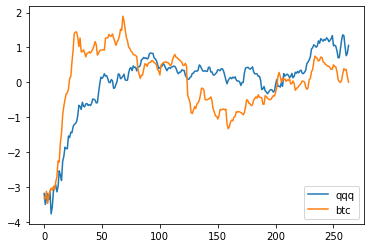

In [5]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

In [6]:
def max_offset(df1, df2):
#     print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

(0, 153.14166296612544)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


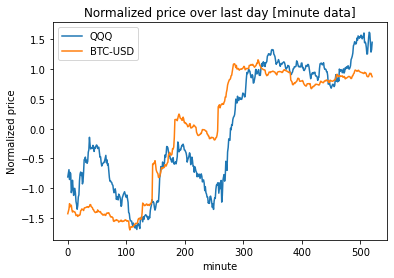

Loss:  0.3848581613763763
10


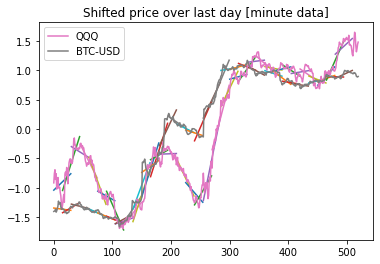

In [47]:
def ticker_offset(str1, str2, silent=False):
    a = yf.download(tickers=str1, period="48h", interval="1m")
    b = yf.download(tickers=str2, period="48h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a']
    y2 = shift_df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    
    f, ax = plt.subplots()
    def slope_loss(k, s):
        diffs = []
        for i in range(0,len(y1)-k, s):
            xs = np.array(range(i,i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            #print("Slope 2", reg2)
            diffs.append(abs(reg1-reg2))
        #print(diffs)
        print("Loss: ", np.sum(diffs))
        
    slope_loss(30, 15)
    if not silent:
        ax.plot(range(len(y1)),y1, label=str1)
        ax.plot(range(len(y2)),y2, label=str2)
        ax.legend()
        ax.set_title("Shifted price over last day [minute data]")
        #ax.ylabel("Normalized price")
        #ax.xlabel("minute")
        #ax.show()
    return offset
print(ticker_offset("QQQ","BTC-USD"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


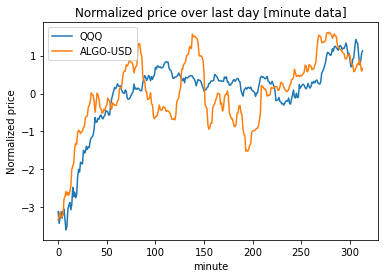

(0, 228.41321217980953)


In [8]:
print(ticker_offset("QQQ","ALGO-USD"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

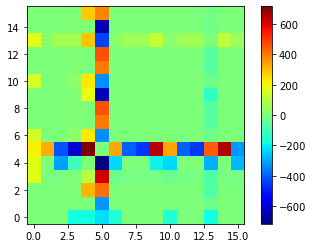

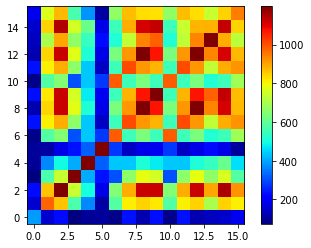

In [9]:
tokens = ["QQQ", "BTC-USD", "ETH-USD", "USDT-USD", "BNB-USD", "USDC-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
offset_matrix = [[None] * len(tokens) for _ in range(len(tokens))] 
max_corr_matrix = [[None] * len(tokens) for _ in range(len(tokens))] 

for idx1, token1 in enumerate(tokens):
    for idx2, token2 in enumerate(tokens):
        offset, max_corr = ticker_offset(token1, token2, silent=True)
        offset_matrix[idx1][idx2] = offset
        max_corr_matrix[idx1][idx2] = max_corr
        
plt.imshow(offset_matrix, interpolation='none', cmap=plt.cm.jet, origin='lower')  
plt.colorbar()
plt.show()

plt.imshow(max_corr_matrix, interpolation='none', cmap=plt.cm.jet, origin='lower')  
plt.colorbar()
plt.show()